Diff: 0
4950 valid pairs for diff 0
Diff: 1
4687 valid pairs for diff 1
Diff: 2
3365 valid pairs for diff 2
Diff: 3
1899 valid pairs for diff 3
Diff: 4
839 valid pairs for diff 4
Diff: 5
290 valid pairs for diff 5
Diff: 6
66 valid pairs for diff 6
Diff: 7
7 valid pairs for diff 7
Diff: 8
0 valid pairs for diff 8
Diff: 9
0 valid pairs for diff 9


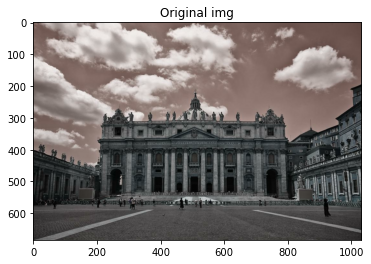

theta: -1.1574602711364779
R:
[[ 0.98347631 -0.09804917  0.1521864 ]
 [-0.09804917  0.41819036  0.90305215]
 [-0.1521864  -0.90305215  0.40166667]]
Translate:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Dst:
[[ 1.14888954e+02 -2.69937598e+03 -9.77885293e+03  1.50374239e+03]
 [ 1.11367558e+03  7.74823133e+03 -1.42294193e+04  1.17741363e+03]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
New dst:
[[ 1.14888954e+02 -2.69937598e+03 -9.77885293e+03  1.50374239e+03]
 [ 1.11367558e+03  7.74823133e+03 -1.42294193e+04  1.17741363e+03]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
original P:
[[ 8.89963869e-01 -6.52938530e-01  9.91439541e+01]
 [-1.60028350e-01  5.04148513e-02  9.61051486e+02]
 [-1.81225667e-04 -1.07536697e-03  8.62954620e-01]]
translate_matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
new P:
[[ 8.89963869e-01 -6.52938530e-01  9.91439541e+01]
 [-1.60028350e-01  5.04148513e-02  9.61051486e+02]
 [-1.81225667e-04 -1.07536697e-03  8.62954620e-01]]
new_

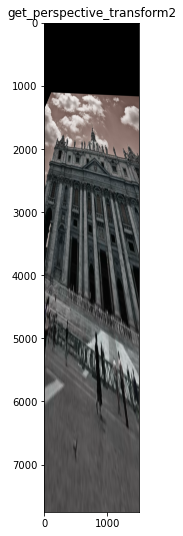

original P:
[[ 8.89963869e-01 -6.52938530e-01  9.91439541e+01]
 [-1.60028350e-01  5.04148513e-02  9.61051486e+02]
 [-1.81225667e-04 -1.07536697e-03  8.62954620e-01]]
scale: 4.147929683079949e-06
normalization: 1
scaled P:
[[ 3.69150755e-06 -2.70834311e-06  4.11242150e-04]
 [-6.63786342e-07  2.09117258e-07  3.98637399e-03]
 [-1.81225667e-04 -1.07536697e-03  8.62954620e-01]]
translate_matrix:
[[  1.           0.         396.83966064]
 [  0.           1.         602.65209961]
 [  0.           0.           1.        ]]
new P:
[[-7.19138408e-02 -4.26750974e-01  3.42455030e+02]
 [-1.09216693e-01 -6.48071956e-01  5.20065400e+02]
 [-1.81225667e-04 -1.07536697e-03  8.62954620e-01]]


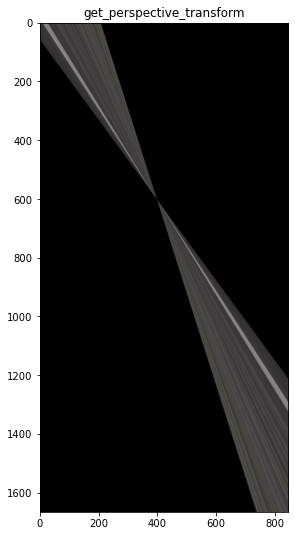

In [31]:
%matplotlib inline
#from pipeline import *
import numpy as np
from scene_info import SceneInfo
import cv2 as cv
import matplotlib.pyplot as plt
import math


def make_homogeneous(column_vecs):
    return np.vstack((column_vecs, np.ones(column_vecs.shape[1])))


def get_rotation_matrix(unit_rotation_vector, theta):

    # Rodrigues formula
    # R = I + sin(theta) . K + (1 - cos(theta)).K**2

    K = np.array([
        [0.0, -unit_rotation_vector[2], unit_rotation_vector[1]],
        [unit_rotation_vector[2], 0.0, -unit_rotation_vector[0]],
        [-unit_rotation_vector[1], unit_rotation_vector[0], 0.0],
    ])
    a = np.eye(3)
    b = math.sin(theta) * K
    c = (1.0 - math.cos(theta)) * K @ K

    R = a + b + c
    return R


def get_rectification_rotation(normal, rotation_factor=1.0):

    # now the normals will be "from" me, "inside" the surfaces
    normal = -normal

    z = np.array([0.0, 0.0, 1.0])

    rotation_vector = np.cross(normal, z)
    rotation_vector_norm = abs_sin_theta = np.linalg.norm(rotation_vector)
    unit_rotation_vector = rotation_vector / rotation_vector_norm
    theta = -math.asin(abs_sin_theta) * rotation_factor
    print("theta: {}".format(theta))

    R = get_rotation_matrix(unit_rotation_vector, theta)
    det = np.linalg.det(R)
    assert math.fabs(det - 1.0) < 0.0001
    return R


def show_transormation(K, normal):
    R = get_rectification_rotation(normal, rotation_factor=1.0)
    print("R:\n{}".format(R))

    T, bounding_box = get_perspective_transform2(R, K, scale=1.0)

    rectified = cv.warpPerspective(img, T, bounding_box)

    plt.figure(figsize=(9, 9))
    plt.title("get_perspective_transform2")
    plt.imshow(rectified)
    plt.show()

    T, bounding_box = get_perspective_transform(R, K, scale=1.0)

    rectified = cv.warpPerspective(img, T, bounding_box)

    plt.figure(figsize=(9, 9))
    plt.title("get_perspective_transform")
    plt.imshow(rectified)
    plt.show()



def get_perspective_transform(R, K, scale=1.0):
    
    K_inv = np.linalg.inv(K)

    unscaled = True
    while unscaled:

        coords = np.where(img[:, :, 0] > 0)
        coords = np.array([coords[1], coords[0]])
        coords = make_homogeneous(coords)

        # I really think I need K (even if estimated)
        P = K @ R @ K_inv
        if scale != 1.0:
            unscaled = False
            print("original P:\n{}".format(P))
            #scale = scale * 10
            print("scale: {}".format(scale))
            P[:2, :] *= scale

        new_coords = P @ coords
        new_coords = new_coords / new_coords[2, :]
        #new_coords[2] = 1.0

        min_row = min(new_coords[1])
        max_row = max(new_coords[1])
        min_col = min(new_coords[0])
        max_col = max(new_coords[0])

        dst = np.float32([[min_col, min_row], [min_col, max_row - 1], [max_col - 1, max_row - 1], [max_col - 1, min_row]])
        dst = np.transpose(dst)
        dst = make_homogeneous(dst)

        if unscaled:
            new_bb_size = (max_row - min_row) * (max_col - min_col)
            # len(coords) * factor(=1.3) = new_bb
            scale = np.sqrt((coords.shape[1] * 2.0) / new_bb_size)
            if scale == 1.0:
                unscaled = False
                break


    translate_vec_new = (-np.min(dst[0]), -np.min(dst[1]))
    normalization = P[2] @ dst[:, 0] 
    normalization = 1
    print("normalization: {}".format(normalization))

    translate_matrix_new = np.array([
        [1, 0, translate_vec_new[0] * normalization],
        [0, 1, translate_vec_new[1] * normalization],
        [0, 0, 1],
    ])
#     translate_matrix_new = np.array([
#         [1, 0, translate_vec_new[0] * normalization],
#         [0, 1, translate_vec_new[1] * normalization],
#         [0, 0, 0],
#     ])

    dst = translate_matrix_new @ dst
    print("scaled P:\n{}".format(P))
    print("translate_matrix:\n{}".format(translate_matrix_new))
    P = translate_matrix_new @ P
    #P = translate_matrix_new + P
    print("new P:\n{}".format(P))
    bounding_box_new = (math.ceil(np.max(dst[0])), math.ceil(np.max(dst[1])))

    return P, bounding_box_new


def get_perspective_transform2(R, K, scale=1.0):

    K_inv = np.linalg.inv(K)
    P = K @ R @ K_inv
    #scale = 4.147929683079949e-05
    #scale = 0.01
    #P[:2, :] *= scale
    
    def get_corners():
        h, w = img.shape[:2]
        corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]])
        corners = np.transpose(corners)
        # homogeneous
        corners = np.vstack((corners, np.ones(corners.shape[1])))
        return corners

    dst = P @ get_corners()
    dst = dst / dst[2, :]

    translate_vec = (-np.min(dst[0]), -np.min(dst[1]))
#     translate_matrix = np.array([
#         [1, 0, translate_vec[0]],
#         [0, 1, translate_vec[1]],
#         [0, 0, 1],
#     ])
    
    translate_matrix = np.eye(3)
    
#     translate_matrix = np.array([
#  [1.00000000e+00, 0.00000000e+00, 3.96839648e+03],
#  [0.00000000e+00, 1.00000000e+00, 6.02652051e+03],
#  [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])        
    
    print("Translate:\n{}".format(translate_matrix))
    print("Dst:\n{}".format(dst))

    dst = translate_matrix @ dst
    print("New dst:\n{}".format(dst))

    print("original P:\n{}".format(P))
    print("translate_matrix:\n{}".format(translate_matrix))
    P = translate_matrix @ P
    print("new P:\n{}".format(P))

    new_corners = P @ get_corners()
    new_corners = new_corners / new_corners[2, :]
    
    print("new_corners:\n{}".format(new_corners))

    bounding_box = (math.ceil(np.max(dst[0])), math.ceil(np.max(dst[1])))
    print("bounding box:\n{}".format(bounding_box))
    return P, bounding_box


    
scene_info = SceneInfo.read_scene("phototourism/st_peters_square", "google", ".jpg")
img_file_path = scene_info.get_img_file_path("99261069_5958624644")
img = cv.imread(img_file_path, None)
plt.figure()
plt.title("Original img")
plt.imshow(img)
plt.show()


K = [[839.76184082,  0.,  516.], 
     [  0.,          839.76184082,  342.], 
     [  0.,          0.,        1.]]


normal = np.array([-0.1521864, -0.90305215, 0.40166667])
show_transormation(K, normal)

